### Import Libraries

In [1]:
#Import Required Python Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
import pickle
from pickle import load
import re
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer,word_tokenize
import rake_nltk
from rake_nltk import Rake
import yake
from yake import KeywordExtractor

### Import Data

In [2]:
#Loading Both SVM and TfidfVectorizer Intelligence for deployment
svm_deploy=load(file=open('svm_deploy_ngram.pkl','rb'))
tf_idf_deploy=load(file=open('tf_idf_deploy_ngram.pkl','rb'))

In [3]:
lemmatizer = WordNetLemmatizer()
w_tokenizer=WhitespaceTokenizer()
stop_words = pd.read_csv('stop.txt',header=None,squeeze=True)

In [4]:
input_review="I was looking for Pet friendly hotel near the vet hospital on ECR that I had to take my pet dog for treatment over 4 days. Green Meadows was reco to me by a good friend living in that area. I am very thankful to him for the reco. I find that Green Meadows offered true value for money covering various aspects of my stay including hygiene, environment, food, staff services and parking. I am so happy for having chosen to stay in Green Meadows and I am looking forward to be back sometime in near future, particularly now that my pet dog is bouncing back to his normal good health after the treatment."

In [5]:
def text_clean(text):
  text=text.lower()
  text=re.sub("\d+","",text) #Remove Numbers
  text=re.sub("\[.*?\]","",text) #Remove text between square brackets
  text=re.sub("\S*https?:\S*","",text) #Remove URLs
  text=re.sub("\S*www?.\S*","",text) #Remove URLs
  text=re.sub("[%s]" % re.escape(string.punctuation),"",text) #Remove All Punctuations
  text=re.sub("\n","",text) #Remove newline space
  text=re.sub(' +', " ", text) #Remove Additional space
  text=text.split() #Split the text into list of words, i.e. tokenization
  text=[word for word in text if word not in list(stop_words)]
  text=' '.join(text)
  return text
cleaned_text=text_clean(input_review)
cleaned_text

'pet friendly hotel vet hospital ecr pet dog treatment days green meadows reco good friend living area thankful reco find green meadows offered true value money covering various aspects stay including hygiene environment food staff services parking happy chosen stay green meadows forward back future pet dog bouncing back normal good health treatment'

In [6]:
def lemmatize(txt):
  list_review=[lemmatizer.lemmatize(word=word, pos=tag[0].lower()) if tag[0].lower() in ['a','r','n','v'] else word for word, tag in pos_tag(word_tokenize(txt))]
  return (' '.join([x for x in list_review if x]))

In [7]:
cleaned=lemmatize(cleaned_text)
cleaned

'pet friendly hotel vet hospital ecr pet dog treatment day green meadow reco good friend live area thankful reco find green meadow offer true value money cover various aspect stay include hygiene environment food staff service park happy choose stay green meadows forward back future pet dog bounce back normal good health treatment'

In [8]:
X=tf_idf_deploy.transform([cleaned])
svm_deploy.predict(X)[0]

2

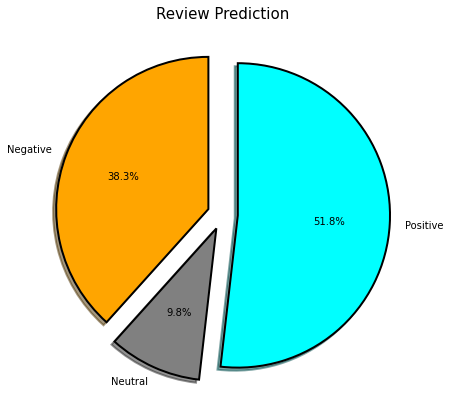

In [9]:
fig = plt.figure(figsize=(10,7))
colors = ("orange", "grey", "cyan")
wp = {'linewidth':2, 'edgecolor':"black"}
predictions = pd.Series(np.ravel(svm_deploy.predict_proba(X)),index=['Negative', 'Neutral', 'Positive'])
explode = (0.1,0.1,0.1)
predictions.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Review Prediction',size=15)
plt.show()

#### Keyword Extraction Through TFIDF

In [10]:
feature_index=X.nonzero()[1]
feature_names=tf_idf_deploy.get_feature_names()
dict_values=dict(zip([feature_names[i] for i in feature_index],[X[0,i] for i in feature_index]))
[x[0] for x in sorted(dict_values.items(),key=lambda x: x[1],reverse=True)][:20]

['pet',
 'meadow',
 'pet dog',
 'green',
 'back',
 'dog',
 'treatment',
 'money cover',
 'park happy',
 'stay green',
 'happy choose',
 'vet',
 'good health',
 'treatment day',
 'pet friendly',
 'service park',
 'hygiene',
 'friend live',
 'bounce',
 'stay include']

#### Keyword Extraction through POS tags - adj, propn, noun, adverb

In [11]:
def positive_negative(txt):
  """
  This function takes text string as input and get only words that are having below pos tags
  ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','RB','RBR','RBS','VB','VBD','VBG','VBN','VBP','VBZ']
  """
  list_review=[wrd if tag in ['JJ','JJR','JJS','NN','NNS','NNP','NNPS','RB','RBR','RBS'] else '' for wrd, tag in pos_tag(w_tokenizer.tokenize(txt))]
  return (' '.join([x for x in list_review if x]))

In [12]:
list(set(positive_negative(cleaned).split()))[:20]

['hospital',
 'meadow',
 'treatment',
 'day',
 'reco',
 'pet',
 'true',
 'health',
 'service',
 'area',
 'back',
 'environment',
 'offer',
 'future',
 'friendly',
 'ecr',
 'green',
 'happy',
 'food',
 'bounce']

#### Keyword Extraction Through Rake

In [14]:
r=Rake()
r.extract_keywords_from_text(input_review)

In [15]:
seen = set()
result = []
for item in r.get_ranked_phrases():
    if item not in seen:
        seen.add(item)
        result.append(item)
result[:20]

['green meadows offered true value',
 'money covering various aspects',
 'pet friendly hotel near',
 'normal good health',
 'good friend living',
 'stay including hygiene',
 'green meadows',
 'near future',
 'pet dog',
 'vet hospital',
 'staff services',
 'bouncing back',
 'back sometime',
 '4 days',
 'looking forward',
 'stay',
 'looking',
 'treatment',
 'thankful',
 'take']

#### Keyword Extraction Through Yake

In [16]:
extract1=KeywordExtractor(n=1,top=20)
[x[0] for x in extract1.extract_keywords(input_review)]

['ECR',
 'Meadows',
 'Green',
 'Pet',
 'days',
 'friendly',
 'hotel',
 'vet',
 'hospital',
 'dog',
 'reco',
 'treatment',
 'good',
 'stay',
 'back',
 'area',
 'friend',
 'living',
 'environment',
 'food']

In [17]:
extract2=KeywordExtractor(n=2,top=20)
[x[0] for x in extract2.extract_keywords(input_review)]

['Green Meadows',
 'friendly hotel',
 'vet hospital',
 'Pet friendly',
 'ECR',
 'pet dog',
 'Meadows',
 'Green',
 'Pet',
 'days',
 'Meadows offered',
 'friendly',
 'hotel',
 'vet',
 'hospital',
 'dog',
 'reco',
 'treatment',
 'friend living',
 'good']

In [18]:
extract3=KeywordExtractor(n=3,top=20)
[x[0] for x in extract3.extract_keywords(input_review)]

['Pet friendly hotel',
 'hospital on ECR',
 'Green Meadows',
 'friendly hotel',
 'vet hospital',
 'Pet friendly',
 'Green Meadows offered',
 'ECR',
 'pet dog',
 'Meadows',
 'Green',
 'Pet',
 'days',
 'Meadows offered true',
 'good friend living',
 'Meadows offered',
 'friendly',
 'hotel',
 'vet',
 'hospital']